In [1]:
!pip install tensorflow
import tensorflow as tf
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [30]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.1 MB/s eta 0:00:00


In [31]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
import tensorflow_addons as tfa

import torch
import torch.nn as nn
import re
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import glob
file_names = glob.glob('/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/*.csv')
print(file_names)

Mounted at /content/drive
['/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CNN_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCFLu_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCtravel_tweets_unique_.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCemergency_tweets_unique.csv', '/content/drive/MyDrive/GA Research Project - Covid Tweet Classification/Twitter_Covid_GAProject/Annotated Data/CDCgov_tweets_unique.csv']


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_data = []
for file_name in file_names:
  temp = pd.read_csv(file_name)
  if 'CDCFLu' in file_name:
    temp = temp.head(50)
  else:
    temp = temp.head(499)
  df_data.append(temp)
df_data = pd.concat(df_data)
print(df_data.shape)
#df_data=df_data.head(500)
print(df_data["Category"].unique())
def clean_text(text):
    text = re.sub(r'RT\s@\w+:\s', '', text) # remove retweet text
    text = re.sub(r'https?:\/\/\S+', '', text) # remove URLs
    text = re.sub(r'&\w+;', '', text) # remove HTML entities
    text = re.sub(r'\d+', '', text) # remove numbers
    text = re.sub(r'\W+', ' ', text) # remove special characters
    text = text.lower() # convert to lowercase
    return text

df_data["clean_text"] = df_data["text"].apply(clean_text)

(2046, 13)
[nan 'Outbreak' 'Vaccine; Outbreak' 'Outbreak; Prevention; Vaccine'
 'Outbreak; Vaccine' 'Outbreak; Symptoms' 'Outbreak; Prevention' 'Vaccine'
 'Prevention' 'Outbreak; Vaccine; Prevention' 'Vaccine; Prevention'
 'Vaccine, Prevention; Symptoms' 'Vaccine, Outbreak' 'Travel; Outbreak'
 'Travel' 'Prevention, Travel' 'Travel; Prevention' 'Prevention; Travel'
 'Symptoms' 'Prevention; Outbreak' 'Prevention: Travel'
 'Prevention; travel' 'Prevntion' 'Outbreak ' 'Vaccine, Travel'
 'Outbreak; Travel' 'outbreak' 'Travel; prevention' 'Travel; Symptoms'
 'Ountbreak' 'outbreak ' 'prevention' ' Outbreak; Prevention'
 ' Prevention' 'Outbrek; Symptoms' 'Outbreak; symptoms'
 'Outbreak; prevention' 'prevention; outbreak' 'Prevention; Outbreak '
 'Outbreak Prevention' 'outbreak, prevention' 'Prevention; outbreak'
 'outbreak; prevention' 'travel; prevention' 'Symptoms; Prevention'
 'Prevention, Outbreak' 'Outbreak; Awarness' 'Prevention; Awarness'
 'Symptoms, Awarness' 'Outbreak;Awareness' 'Outb

In [6]:
# Filtering the rare terms.
df_data_filtered = df_data.groupby("Category").filter(lambda x: len(x) >1)
df_data_filtered.shape
print(df_data_filtered["Category"])
df_data_filtered["Category"]=[''.join(i.split()).lower() for i in df_data_filtered["Category"]]

def filter_category(categories):
  #options = ['travel', 'outbreak','prevention','vaccine','symptoms']
  if ',' in categories:
    category_list = categories.split(',')
  elif ';' in categories:
    category_list = categories.split(';')
  else:
    category_list = [categories]

  #print(category_list)
  '''
  temp = []
  for item in category_list:
    item = item.strip().lower()
    if 'awarness' == item:
      continue
    temp.append(item.strip())
  #print('temp =', temp)
  '''
  return category_list

df_data_filtered["Category"] = df_data_filtered["Category"].apply(filter_category)

labels=[item for item in df_data_filtered["Category"]]



print(labels)

2                  Outbreak
4                  Outbreak
12        Vaccine; Outbreak
28        Outbreak; Vaccine
39                 Outbreak
               ...         
487    Prevention; Awarness
488              Prevention
490                Symptoms
492              Prevention
496                Symptoms
Name: Category, Length: 938, dtype: object
[['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'vaccine'], ['outbreak'], ['outbreak', 'symptoms'], ['outbreak', 'vaccine'], ['outbreak', 'vaccine'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['vaccine', 'outbreak'], ['outbreak', 'prevention'], ['vaccine'], ['vaccine', 'outbreak'], ['prevention'], ['vaccine'], ['vaccine', 'outbreak'], ['vaccine'], ['outbreak'], ['vaccine'], ['outbreak'], ['outbreak'], ['outbreak', 'vaccine'], ['outbreak', 'prevention'], ['outbreak'], ['outbreak'], ['vaccine', 'outbreak'], ['outbreak'], ['vaccin

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
mlb = MultiLabelBinarizer()
a = mlb.fit_transform(labels)
pd.DataFrame(a, columns=mlb.classes_)
final_text=[text for text  in df_data_filtered["clean_text"]]

labels=[lab for lab  in a]

lab,c =np.unique(a, axis=0, return_counts=True)

print(lab,c)
print(mlb.classes_)
print("total",sum(c))
print(final_text[0])

[[0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 1 0 1 0]
 [0 0 1 1 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 1]
 [0 1 0 0 1 0]
 [0 1 0 1 0 0]
 [0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 0 0 0]] [ 12 142  18 207   2  50   2 341  27   8  11 100   5  13]
['awarness' 'outbreak' 'prevention' 'symptoms' 'travel' 'vaccine']
total 938
b europe is now trading more goods with china than the united states a sign of how the pandemic is transforming the global economy the overall value of eu china goods trade last year was billion about billion more than between the eu and the us 


In [8]:
lnew=np.zeros((len(labels),5));
#print("before",labels)
for i,l in enumerate(labels):
  lnew[i,:]=l[1:]
final_label=lnew

In [10]:
lnew[:10], len(lnew)

(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.]]),
 938)

In [14]:
final_text[0]

'b europe is now trading more goods with china than the united states a sign of how the pandemic is transforming the global economy the overall value of eu china goods trade last year was billion about billion more than between the eu and the us '

In [42]:
# Define constants
MAX_SEQUENCE_LENGTH = 350  # Define the maximum sequence length
VOCAB_SIZE = 10000  # Define the vocabulary size
EMBEDDING_DIM = 100  # Define the dimension of word embeddings
NUM_CLASSES = 5  # Define the number of classes
NUM_EPOCHS = 50
BATCH_SIZE = 32

In [43]:
max_seq_length = np.max([len(text) for text in final_text])
print("Maximum sequence length:", max_seq_length)

Maximum sequence length: 312


In [44]:
# preprocess and tokenize the text data using TensorFlow's Tokenizer:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [51]:
# Initialize Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(final_text)

# Convert text data to sequences of integers
sequences = tokenizer.texts_to_sequences(final_text)

# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Check the shape of padded_sequences
print("Shape of padded_sequences:", padded_sequences.shape)

Shape of padded_sequences: (938, 350)


In [52]:
len(lnew)

938

In [53]:
# Define your X and y variables
X = padded_sequences
y = lnew

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=95)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=95)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 750
Validation set size: 94
Test set size: 94


In [54]:
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score



In [55]:
# Define the CNN architecture
model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

    # Convolutional layers
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.GlobalMaxPooling1D(),

    # Fully connected layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [56]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(NUM_CLASSES)])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 350, 100)          1000000   
                                                                 
 conv1d_14 (Conv1D)          (None, 350, 64)           19264     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 175, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 175, 128)          24704     
                                                                 
 conv1d_16 (Conv1D)          (None, 175, 128)          49280     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 87, 128)           0         
 g1D)                                                 

In [57]:
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/50
24/24 [==============================] - 10s 294ms/step - loss: 0.5189 - accuracy: 0.4507 - precision_5: 0.5294 - recall_5: 0.1463 - f1_score: 0.2094 - val_loss: 0.4185 - val_accuracy: 0.5532 - val_precision_5: 0.6667 - val_recall_5: 0.0721 - val_f1_score: 0.1425
Epoch 2/50
24/24 [==============================] - 8s 350ms/step - loss: 0.4475 - accuracy: 0.5000 - precision_5: 0.5476 - recall_5: 0.2990 - f1_score: 0.1548 - val_loss: 0.4002 - val_accuracy: 0.5532 - val_precision_5: 0.6622 - val_recall_5: 0.4414 - val_f1_score: 0.1425
Epoch 3/50
24/24 [==============================] - 7s 295ms/step - loss: 0.4050 - accuracy: 0.5133 - precision_5: 0.6492 - recall_5: 0.3629 - f1_score: 0.1579 - val_loss: 0.3787 - val_accuracy: 0.5532 - val_precision_5: 0.7679 - val_recall_5: 0.3874 - val_f1_score: 0.1425
Epoch 4/50
24/24 [==============================] - 8s 316ms/step - loss: 0.3568 - accuracy: 0.5987 - precision_5: 0.8049 - recall_5: 0.3575 - f1_score: 0.2912 - val_loss: 0.345

In [68]:
# Evaluate the model
evaluation_result = model.evaluate(X_val, y_val)

# Extract loss and accuracy
loss = evaluation_result[0]
accuracy = evaluation_result[1]

# Calculate precision, recall, and F1 score
y_pred = model.predict(X_val)
precision, recall, f1, _ = precision_recall_fscore_support(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')

# Print evaluation metrics
print('Test Loss:', loss*100)
print('Test Accuracy:', accuracy*100)
print('Test Precision:', precision*100)
print('Test Recall:', recall*100)
print('Test F1 Score:', f1*100)


3/3 [==============================] - 0s 131ms/step
Test Loss: 70.06394267082214
Test Accuracy: 63.82978558540344
Test Precision: 68.67940889217485
Test Recall: 63.829787234042556
Test F1 Score: 64.97416772654438


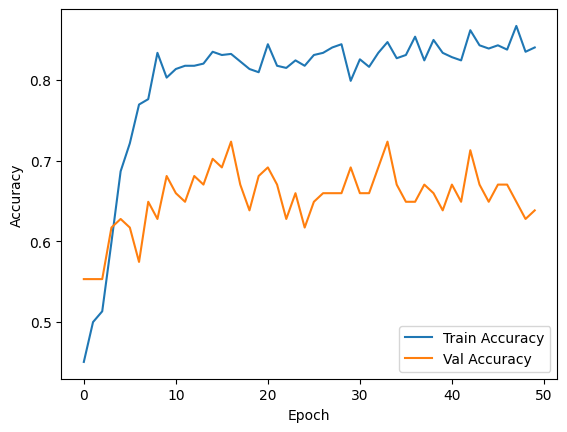

In [69]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_metrics(history)